In [1]:
# Benchmark: IncidenceGraph vs. list-of-tuples
# - Build time
# - Neighbor query time
# - Degree query time
# - Edge existence check time
# - Memory estimate (rough)
#
# Notes:
# - Baseline is a naive list of (u, v) tuples without any index.
# - Random directed graphs with average degree ~= 8.
# - Sizes/trials kept modest to finish quickly in a notebook.
# - Results are displayed and also saved to CSV.

import importlib.util, random, time, sys, math, pandas as pd
import matplotlib.pyplot as plt

MODULE_PATH = "layered_incidence_graph.py" 

spec = importlib.util.spec_from_file_location("incidence_module", MODULE_PATH)
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)
IncidenceGraph = mod.IncidenceGraph



In [3]:
# Workload generators and helpers
def gen_graph_data(n_nodes, avg_deg=8, seed=123):
    """Generate nodes and directed edges with no self-loops."""
    rng = random.Random(seed)
    edges = []
    m = n_nodes * avg_deg
    for _ in range(m):
        u = rng.randrange(n_nodes)
        v = rng.randrange(n_nodes - 1)
        if v >= u:
            v += 1
        edges.append((f"n{u}", f"n{v}"))
    return [f"n{i}" for i in range(n_nodes)], edges

def build_incidence_graph(nodes, edges):
    g = IncidenceGraph(directed=True)
    for n in nodes:
        g.add_node(n)
    for (u, v) in edges:
        g.add_edge(u, v)
    return g

def build_list_of_tuples(nodes, edges):
    # naive baseline: just keep the edges as a Python list of 2-tuples
    return list(edges)



In [5]:
# Operations to benchmark 
def neighbors_incidence(g, node_ids):
    for u in node_ids:
        _ = g.neighbors(u)

def neighbors_list_tuples(edge_list, node_ids):
    for u in node_ids:
        nbrs = set()
        for (a, b) in edge_list:
            if a == u: nbrs.add(b)
            if b == u: nbrs.add(a)

def degree_incidence(g, node_ids):
    for u in node_ids:
        _ = g.degree(u)

def degree_list_tuples(edge_list, node_ids):
    for u in node_ids:
        deg = 0
        for (a, b) in edge_list:
            if a == u or b == u:
                deg += 1

def has_edge_incidence(g, pairs):
    for (u, v) in pairs:
        _ = g.has_edge(u, v)

def has_edge_list_tuples(edge_list, pairs):
    s = set(edge_list)  # one-time set conversion for a fairer presence test
    for (u, v) in pairs:
        _ = (u, v) in s

def mem_bytes_list_tuples(edge_list):
    # Very rough: list + tuple containers (strings not fully counted).
    total = sys.getsizeof(edge_list)
    for t in edge_list:
        total += sys.getsizeof(t)
    return total

def ms(fn):
    t0 = time.perf_counter()
    fn()
    return (time.perf_counter() - t0) * 1e3



In [7]:
# Benchmark runner
def run_bench(
    sizes=(1000, 3000),
    trials=2,
    avg_deg=8,
    q_nodes=50,
    q_pairs=50,
    seed=123
):
    rows = []
    for n in sizes:
        for trial in range(trials):
            nodes, edges = gen_graph_data(n, avg_deg=avg_deg, seed=seed + trial)

            # Build
            t0 = time.perf_counter()
            g = build_incidence_graph(nodes, edges)
            t1 = time.perf_counter()
            elist = build_list_of_tuples(nodes, edges)
            t2 = time.perf_counter()

            # Queries
            qn = random.sample(nodes, min(q_nodes, len(nodes)))
            qp = [(random.choice(nodes), random.choice(nodes)) for _ in range(q_pairs)]

            neighbors_inc_ms = ms(lambda: neighbors_incidence(g, qn))
            neighbors_lst_ms = ms(lambda: neighbors_list_tuples(elist, qn))
            degree_inc_ms    = ms(lambda: degree_incidence(g, qn))
            degree_lst_ms    = ms(lambda: degree_list_tuples(elist, qn))
            has_inc_ms       = ms(lambda: has_edge_incidence(g, qp))
            has_lst_ms       = ms(lambda: has_edge_list_tuples(elist, qp))

            mem_inc = g.memory_usage()           # custom estimate from class
            mem_lst = mem_bytes_list_tuples(elist)

            rows.append({
                "n_nodes": n,
                "n_edges": len(edges),
                "trial": trial + 1,
                "build_incidence_ms": (t1 - t0) * 1e3,
                "build_list_ms": (t2 - t1) * 1e3,
                "neighbors_incidence_ms": neighbors_inc_ms,
                "neighbors_list_ms": neighbors_lst_ms,
                "degree_incidence_ms": degree_inc_ms,
                "degree_list_ms": degree_lst_ms,
                "has_edge_incidence_ms": has_inc_ms,
                "has_edge_list_ms": has_lst_ms,
                "mem_incidence_bytes": mem_inc,
                "mem_list_bytes": mem_lst,
            })
    df = pd.DataFrame(rows)
    summary = (
        df.groupby(["n_nodes", "n_edges"])
          .mean(numeric_only=True)
          .reset_index()
          .sort_values("n_nodes")
    )
    return df, summary

raw_df, summary_df = run_bench()


,n_nodes,n_edges,trial,build_incidence_ms,build_list_ms,neighbors_incidence_ms,neighbors_list_ms,degree_incidence_ms,degree_list_ms,has_edge_incidence_ms,has_edge_list_ms,mem_incidence_bytes,mem_list_bytes
0,1000,8000,1,217.599,0.056,62.899,13.595,105.806,12.693,14.499,0.445,1892000,512056
1,1000,8000,2,156.380,0.235,53.392,13.844,136.263,12.709,14.249,0.384,1892000,512056
2,3000,24000,1,512.393,0.360,186.005,48.969,335.164,48.307,52.234,1.525,5676000,1536056
3,3000,24000,2,548.961,0.716,169.645,43.859,400.449,43.679,46.780,1.851,5676000,1536056


,n_nodes,n_edges,trial,build_incidence_ms,build_list_ms,neighbors_incidence_ms,neighbors_list_ms,degree_incidence_ms,degree_list_ms,has_edge_incidence_ms,has_edge_list_ms,mem_incidence_bytes,mem_list_bytes
0,1000,8000,1.5,186.989,0.145,58.146,13.719,121.034,12.701,14.374,0.414,1892000.0,512056.0
1,3000,24000,1.5,530.677,0.538,177.825,46.414,367.806,45.993,49.507,1.688,5676000.0,1536056.0


Saved: benchmark_trials.csv, benchmark_summary.csv


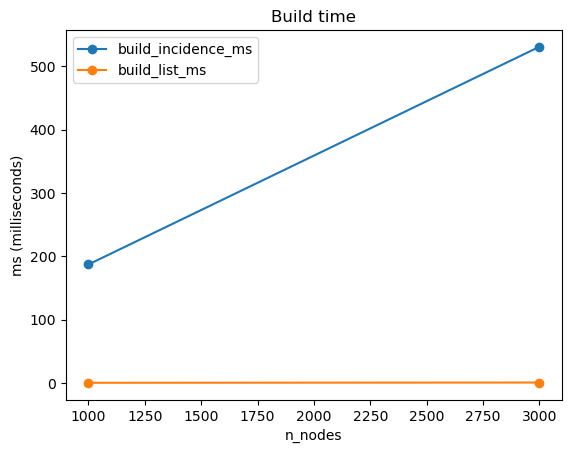

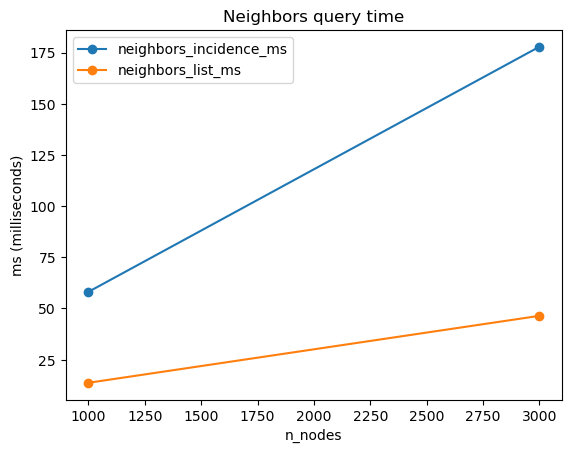

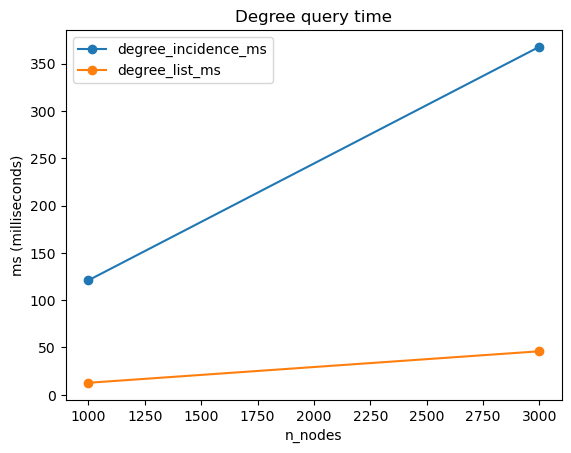

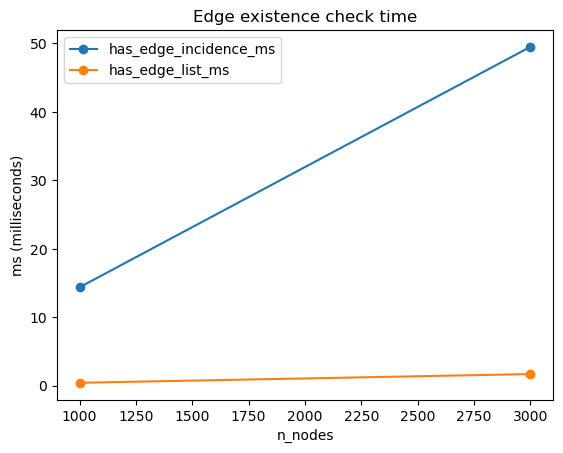

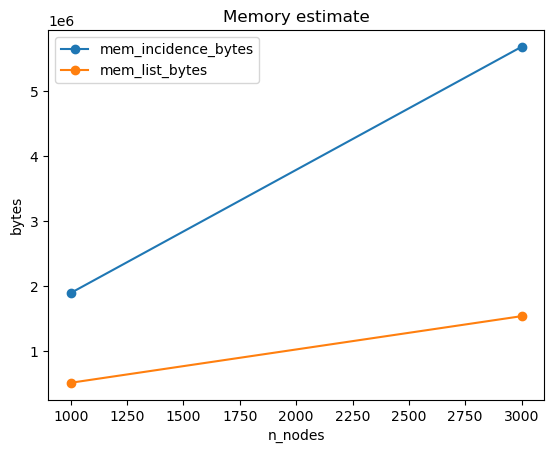

In [9]:

# Display + save
from IPython.display import display
display(raw_df.round(3))
display(summary_df.round(3))

raw_df.to_csv("benchmark_trials.csv", index=False)
summary_df.to_csv("benchmark_summary.csv", index=False)
print("Saved: benchmark_trials.csv, benchmark_summary.csv")

# plots
def plot2(df, x, y1, y2, ylabel, title):
    plt.figure()
    plt.plot(df[x], df[y1], marker='o', label=y1)
    plt.plot(df[x], df[y2], marker='o', label=y2)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

plot2(summary_df, "n_nodes", "build_incidence_ms", "build_list_ms", "ms (milliseconds)", "Build time")
plot2(summary_df, "n_nodes", "neighbors_incidence_ms", "neighbors_list_ms", "ms (milliseconds)", "Neighbors query time")
plot2(summary_df, "n_nodes", "degree_incidence_ms", "degree_list_ms", "ms (milliseconds)", "Degree query time")
plot2(summary_df, "n_nodes", "has_edge_incidence_ms", "has_edge_list_ms", "ms (milliseconds)", "Edge existence check time")
plot2(summary_df, "n_nodes", "mem_incidence_bytes", "mem_list_bytes", "bytes", "Memory estimate")
